/Users/jaekunpark/Dataset
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)          

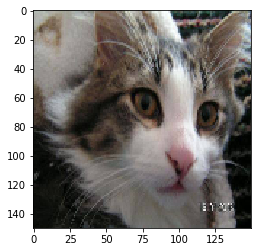

(1, 148, 148, 32)


/Users/jaekunpark/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


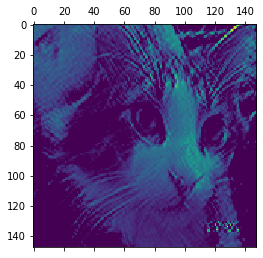

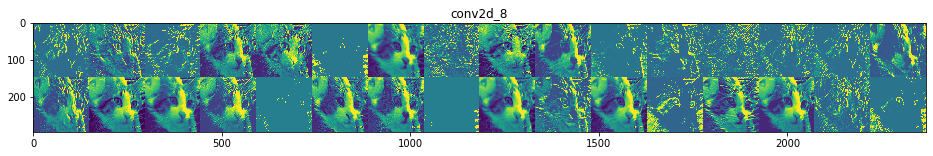

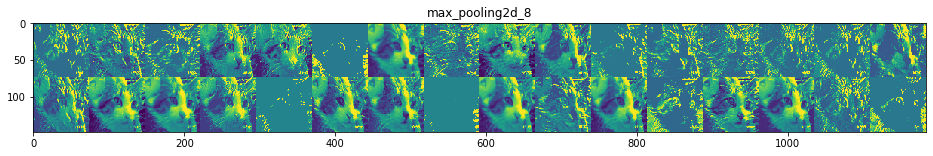

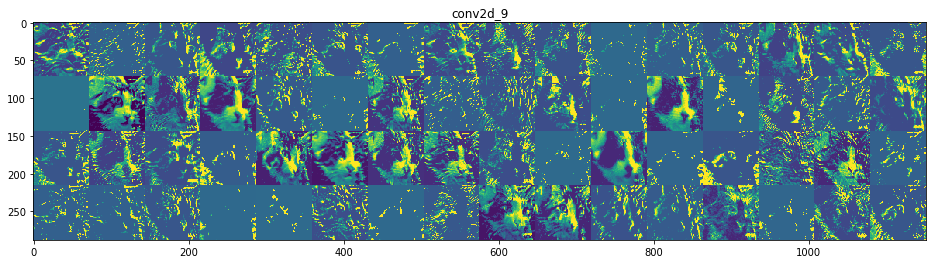

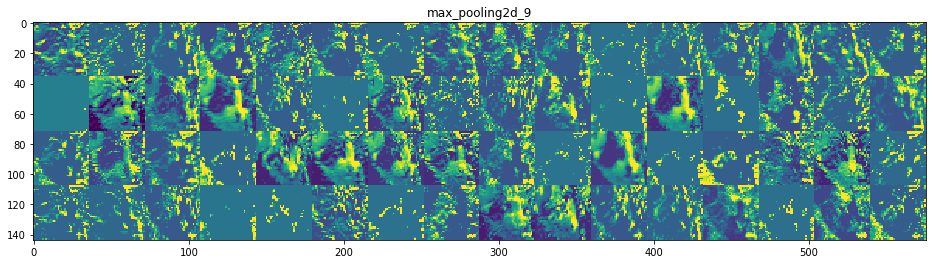

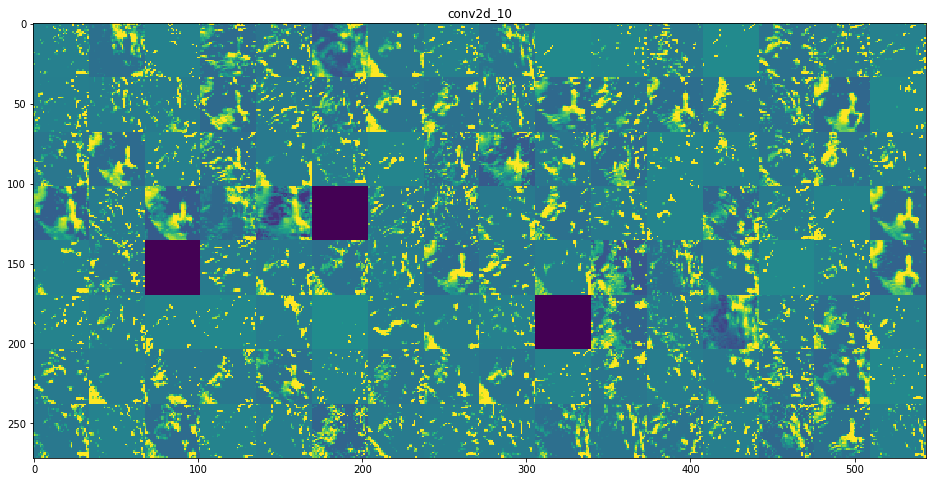

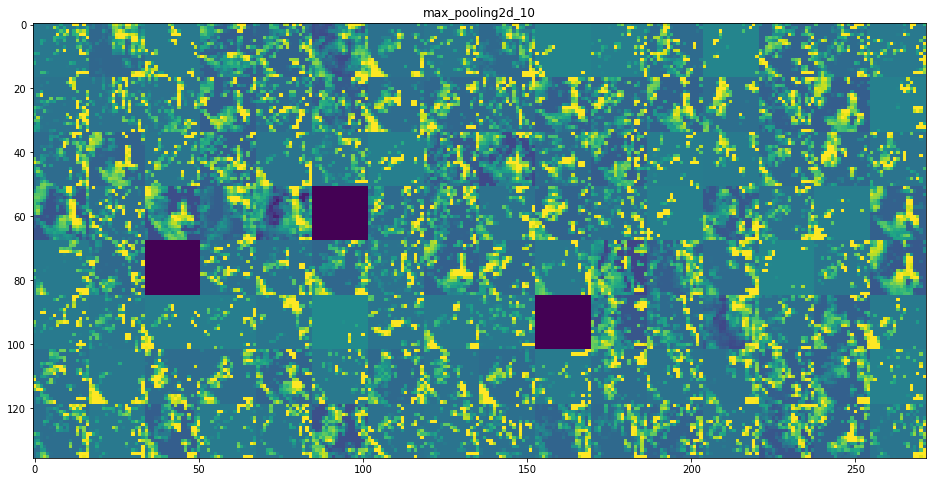

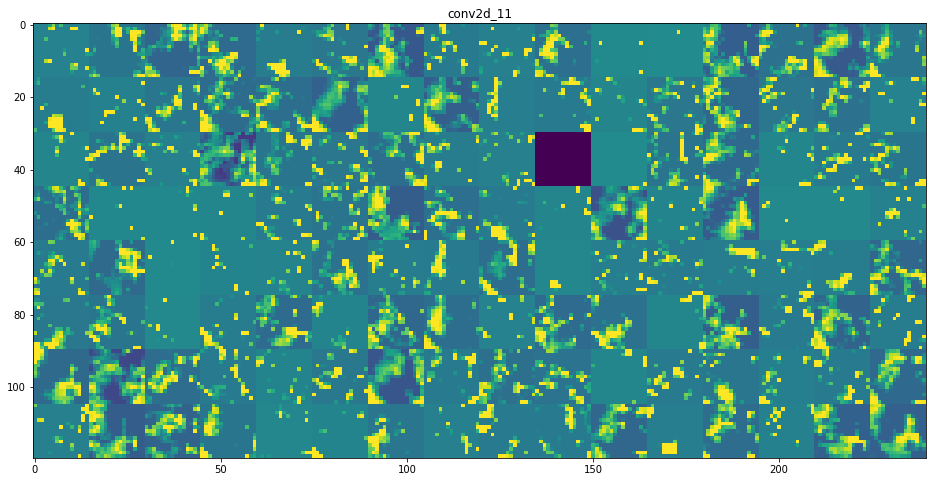

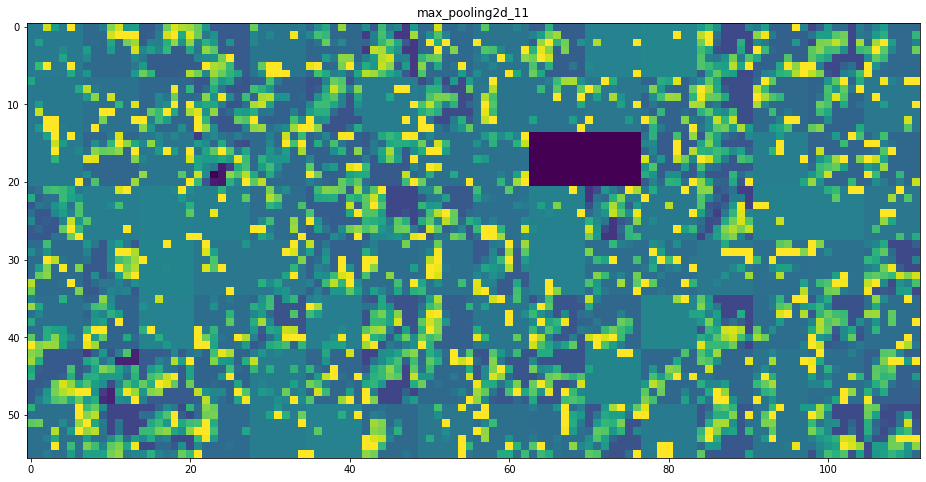

CPU times: user 2.14 s, sys: 55.1 ms, total: 2.19 s
Wall time: 2.11 s


In [12]:
%%time

# 컨브넷 중간층의 출력(중간층에 있는 활성화)을 시각화하기 :
#연속된 컨브넷 층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 된다.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 저장했던 모델 불러오기
currentPath = os.getcwd()
print(currentPath)
os.chdir('/Users/jaekunpark/Dataset')

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

# 개별 이미지 전처리

img_path = '/Users/jaekunpark/Dataset/CatDog/partial/test/cats/cat.1752.jpg'

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
    # 이미지를 4차원 텐서로 변환 (배치 차원 추가)
img_tensor /= 255.
#print(img_tensor.shape)
    #(1, 150, 150, 3)

# 테스트 사진 출력하기

plt.imshow(img_tensor[0])
plt.show()

# 입력 텐서와 출력 텐서의 리스트로 모델 객체 만들기

layer_outputs = [layer.output for layer in model.layers[:8]] 
    # 상위 8개 층을 출력

activation_model = models.Model(inputs = model.input, outputs = layer_outputs) 
    # 입력에 대해 8개층의 출력을 반환하는 모델 생성

# 예측 모드로 모델 실행하기
activations = activation_model.predict(img_tensor)
    # 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트 반환


first_layer_activation = activations[0]

print(first_layer_activation.shape)
    # (1, 148, 148, 32)

# 20번째 채널 시각화하기
plt.matshow(first_layer_activation[0, :, :, 19], cmap = 'viridis')


# 중간층에 있는 모든 활성화에 있는 채널 시각화하기
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name) # 층의 이름을 그래프 제목으로 사용

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # 특성 맵 그리기
    n_features = layer_activation.shape[-1] # 특성 맵에 있는 특성의 수
    
    size = layer_activation.shape[1] # 특성 맵의 크기는 (1, size, size, n_features)
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # 그래프로 나타내기 좋게 특성을 처리
            channel_image /= channel_image.std()
# 임의의 실수인 층의 출력을 픽셀로 표현이 가능한 0~255 사이의 정수로 바꾼다. 먼저 평균을 뺴고 표준편차로 나누어 표준점수로 바꾼다.
# 그 다음 표준 점수 2.0 이내의 값(약 95%)들이 0~255 사이에 놓이도록 증폭시킨 후 클리핑
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image # 그리드 출력
            
    scale = 1. / size
    plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')
    
plt.show()
